<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-practicres/blob/main/Transfer_learning_and_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import tensorflow as tf
print(tf.__version__)

2.8.0


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Data Preprocessing
###Download data

In [3]:
data_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cat_and_dogs.zip', origin=data_url, extract=True)
print(path_to_zip)


68616192/68606236 [==============================] - 2s 0us/step
/root/.keras/datasets/cat_and_dogs.zip


In [4]:
data_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    shuffle=True, 
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


##Show the first nine examples

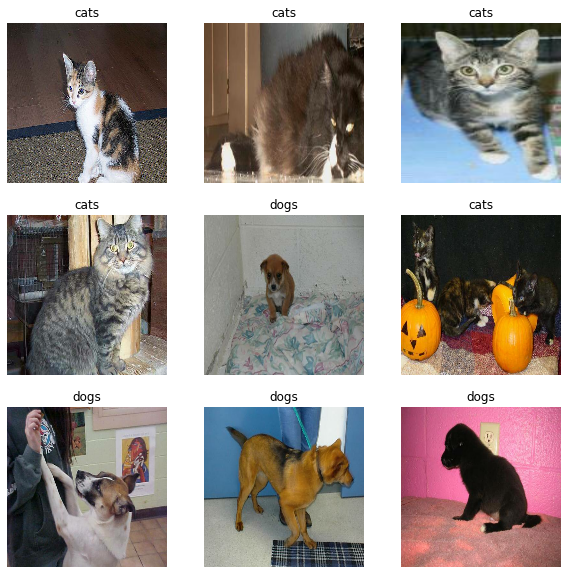

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
print(val_batches)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print(tf.data.experimental.cardinality(test_dataset))
print(tf.data.experimental.cardinality(validation_dataset))

tf.Tensor(32, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(26, shape=(), dtype=int64)


In [7]:
# Configure the dataset
AUTOMATE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

###Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomFlip('horizontal'),
     tf.keras.layers.RandomRotation(0.2),
     tf.keras.layers.RandomZoom(0.1)
    ]
)

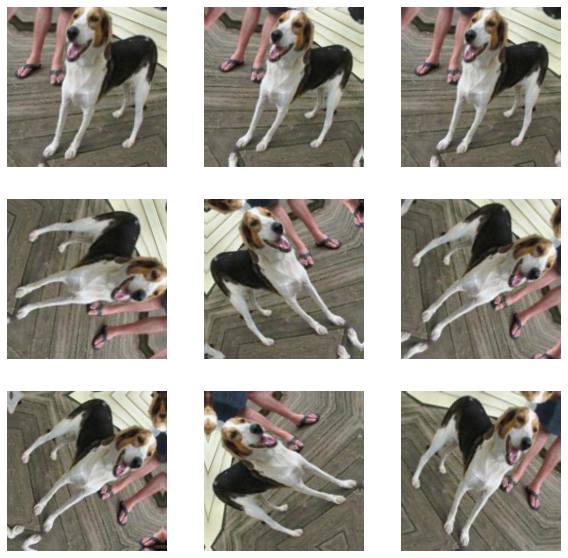

In [9]:
# Repeatedly apply augmentation
plt.figure(figsize=(10, 10))

for image , _ in train_dataset.take(1):
    first_image = image[0]
    for i in range(9):
        plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255.)
        plt.axis('off')

In [10]:
# Rescale inputs
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights='imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [12]:
# Freeze the convolutional base model
base_model.trainable = False

In [13]:
# Take a look at base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avrage = global_average_layer(feature_batch)
print(feature_batch_avrage.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_avrage)
print(prediction_batch.shape)

(32, 1)


##Build a model using tensorflow functional API

In [16]:
inputs = tf.keras.layers.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


###Compile the model

In [17]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [18]:
len(model.trainable_variables)

2

##Train the model

In [19]:
initial_epochs = 10

loss0, acc0 = model.evaluate(validation_dataset)
print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(acc0))

26/26 [==============================] - 5s 61ms/step - loss: 0.7095 - accuracy: 0.5297
Initial loss: 0.71
Initial accuracy: 0.53


In [20]:
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset
)

Epoch 1/10
63/63 [==============================] - 10s 92ms/step - loss: 0.6460 - accuracy: 0.6095 - val_loss: 0.4885 - val_accuracy: 0.7203
Epoch 2/10
63/63 [==============================] - 6s 91ms/step - loss: 0.4839 - accuracy: 0.7395 - val_loss: 0.3524 - val_accuracy: 0.8032
Epoch 3/10
63/63 [==============================] - 6s 88ms/step - loss: 0.4065 - accuracy: 0.7920 - val_loss: 0.2782 - val_accuracy: 0.8886
Epoch 4/10
63/63 [==============================] - 6s 87ms/step - loss: 0.3453 - accuracy: 0.8415 - val_loss: 0.2352 - val_accuracy: 0.9109
Epoch 5/10
63/63 [==============================] - 6s 88ms/step - loss: 0.3107 - accuracy: 0.8540 - val_loss: 0.1991 - val_accuracy: 0.9270
Epoch 6/10
63/63 [==============================] - 6s 89ms/step - loss: 0.2809 - accuracy: 0.8755 - val_loss: 0.1762 - val_accuracy: 0.9406
Epoch 7/10
63/63 [==============================] - 6s 86ms/step - loss: 0.2590 - accuracy: 0.8830 - val_loss: 0.1570 - val_accuracy: 0.9455
Epoch 8/10
6

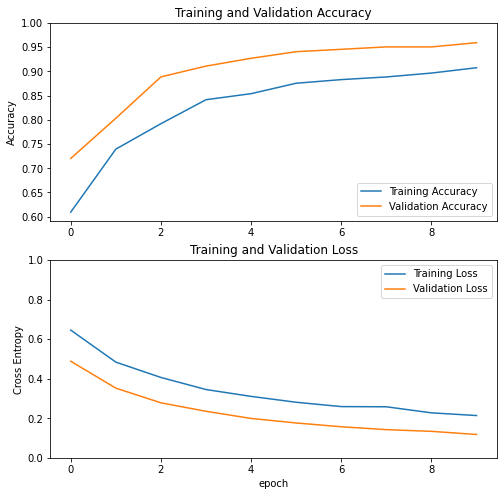

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##ّFine Tuning MobileNetV2

In [22]:
# Unfreeze the top layers
base_model.trainable = True

print("Number of layers in the base model:", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_from = 100

for layer in base_model.layers[: fine_tune_from]:
    layer.trainable = False

Number of layers in the base model: 154


##Compile fine-tuning model

In [23]:
# As you are training a much larger model and want to readapt the pretrained 
# weights, it is important to use a lower learning rate at this stage. 
# Otherwise, your model could overfit very quickly.
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [24]:
len(model.trainable_variables)

56

##Continue trainig the model

In [25]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
fine_history = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset
)

Epoch 10/20
63/63 [==============================] - 15s 134ms/step - loss: 0.1610 - accuracy: 0.9310 - val_loss: 0.0592 - val_accuracy: 0.9851
Epoch 11/20
63/63 [==============================] - 8s 117ms/step - loss: 0.1327 - accuracy: 0.9450 - val_loss: 0.0860 - val_accuracy: 0.9752
Epoch 12/20
63/63 [==============================] - 8s 118ms/step - loss: 0.1227 - accuracy: 0.9460 - val_loss: 0.0388 - val_accuracy: 0.9876
Epoch 13/20
63/63 [==============================] - 9s 146ms/step - loss: 0.1018 - accuracy: 0.9630 - val_loss: 0.0404 - val_accuracy: 0.9876
Epoch 14/20
63/63 [==============================] - 9s 135ms/step - loss: 0.1152 - accuracy: 0.9555 - val_loss: 0.0380 - val_accuracy: 0.9889
Epoch 15/20
63/63 [==============================] - 9s 144ms/step - loss: 0.0986 - accuracy: 0.9595 - val_loss: 0.0344 - val_accuracy: 0.9913
Epoch 16/20
63/63 [==============================] - 10s 152ms/step - loss: 0.0975 - accuracy: 0.9605 - val_loss: 0.0295 - val_accuracy: 0.98

In [26]:
# Visualize the fine tuniing
acc += fine_history.history['accuracy']
val_acc += fine_history.history['val_accuracy']

loss += fine_history.history['loss']
val_loss += fine_history.history['val_loss']

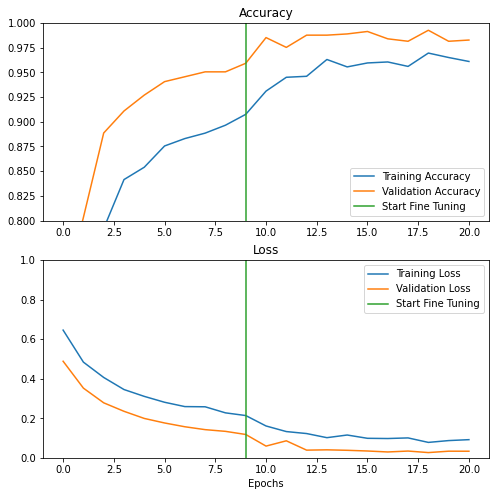

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title("Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.show()

###Evaluate fine-tuned model

In [29]:
loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy: {:.4f}% and Loss: {:.4f}".format(accuracy*100, loss))

6/6 [==============================] - 1s 90ms/step - loss: 0.0377 - accuracy: 0.9844
Test accuracy: 98.4375% and Loss: 0.0377


###Use this model to predict if your pet is a cat or dog

In [35]:
# Retrieve a batch of test dataset
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

Predictions:
 [1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0]
Labels:
 [1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0]


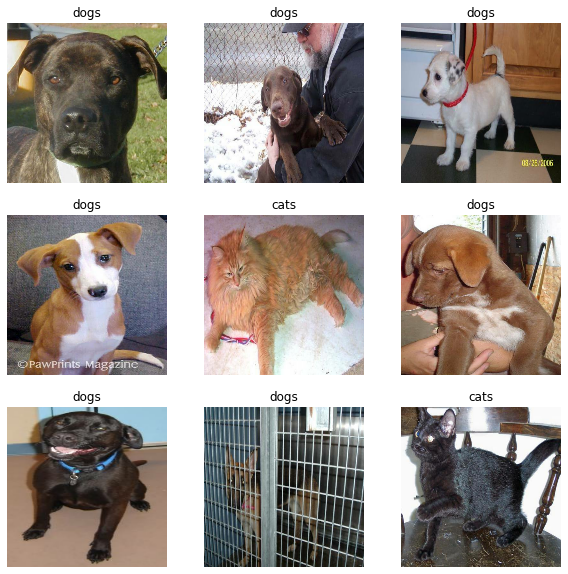

In [37]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(class_names[predictions[i]])
    plt.axis('off')

plt.show()